## 优化器

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

先定义一个网络

In [ ]:
class TestNet(nn.Module):
    def __init__(self):
        super(TestNet, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(13, 10),
            nn.ReLU(),
        )
        self.regression = nn.Linear(10, 1)
    
    def forward(self, x):
        x = self.hidden(x)
        output = self.regression(x)
        return output

In [ ]:
testnet = TestNet()
print(testnet)

设置优化器——设置统一的优化器，所有层的学习率都相同

In [ ]:
optimizer = optim.Adam(testnet.parameters(), lr = 0.001)#其他还有SGD, RMSprop, Adagrad等

为不同的层设置不同学习率的优化器。采用字典的形式

In [ ]:
optimizer = optim.Adam([{'params': testnet.hidden.parameters(), 'lr': 0.001},
                        {'params': testnet.regression.parameters(), 'lr': 0.01}],
                        lr = 1e-2)

在这一步中，我们为hidden层设置学习率0.001；regression层设置学习率0.01。r=1e-2(10的-2次方0.01)将作用于其他没有特殊指定的所有参数

在训练时。在每一个batch中，我们都会调用testnet(input)去前向输出当前网络参数的拟合值pred。然后我们在调用损失函数求得output和target之间的误差。optimizer.zero_grad()能在反向传播之间清空历史梯度信息。optimizer.step()进行参数更新。具体例子如下：

In [ ]:
criteon = nn.CrossEntropyLoss()#交叉熵损失
for input, target in dataset:
    optimizer.zero_grad()#清空历史梯度
    output = testnet(input)#输出当前参数的拟合结果
    print(output.shape)
    loss = criteon(output, target)
    print('loss : {}'.format(loss))
    loss.backward()
    optimizer.step()

学习率优化器

In [ ]:
lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch = -1)#optimizer是优化器， last_epoch表示开始训练后即开始调整学习率

lr_scheduler.StepLR(optimizer, step_size, gamma, last_epoch = -1) #每隔step_size个epoch调整学习率为原来的gamma倍

lr_scheduler.MultiStepLR(optimizer, milestones, gamma = 0.1, last_epoch = -1)

lr_scheduler.ExponentialLR(optimizer, gamma, last_epoch = -1) #指数衰减， lr = lr*gamma^(epoch)


## 损失函数

深度学习的优化方法直接作用的对象是损失函数。损失函数是用来表示预测与实际数据之间的差距程度，一个最优化问题的目标就是将损失函数最小化。
Pytorch的nn模块提供了可直接使用的损失函数，如交叉熵，均方损失等

In [ ]:
criteon = nn.MSELoss(size_averatge = None, reduce = None, reduction = 'mean')
#reduction一般取none，mean，sum。取mean则实际计算的损失为: 1/N[(xi - yi)^2]; 取sum则不会除以N

In [ ]:
criteon = nn.CrossEntropyLoss(weight = None, size_average = None, ignore_index = -100, reduce = None, reduction = 'mean')


## 防止过拟合

什么是过拟合：
    过拟合通常是指针对训练好的深度学习网络，在使用训练数据集训练时，在训练数据集上能够获得很高的识别精度（针对分类问题），或者很低的均方误差（针对回归问题），但是把训练好的模型作用于测试集进行预测时，预测效果往往不是很理想。深度学习网络通常会有大量的可训练的参数，参数使网络具有很强的表达能力，使其在很多领域的性能超过了众多的“传统”机器学习方法。但众多的参数也带来了深度学习网络更容易得到过拟合的训练结果。

防止过拟合的措施：
    1.增加数据量：数据量越少，过拟合发生的可能性越大。更多的训练样本通常会使模型更加稳定，所以训练样本的增加不仅可以得到更有效的训练结果，也能自一定程度上防止过拟合，增加网络的泛化能力。数据增强是一种扩充数据集的方法，如在图像中，我们通过切割，缩放，旋转，平移，增加噪声都可扩充数据。另外，基于GAN生成数据集也是一种可取的方法。
    2.正则化：正则化通常是在损失函数上添加对训练参数的惩罚范数，通过添加的范数乘法对需要训练的参数进行约束，降低参数权重，防止模型过拟合。通常的正则化参数有L1和L2范数。L1参数的目的是将参数的绝对值最小化，L2范数的目的是将参数的平方和最小化。在线性回归中，Lasso回归使用L1正则化；Ridge回归采用L2正则化
    3.Dropout：Dropout操作会以一定概率随机丢掉神经元，即在每个训练批次中，通过忽略一定百分比的神经元数量（通常是一半的神经元），减轻网络的过拟合现象。Dropout和正则化操作一样，都会使模型不会过度依赖某些局部的特征。Dropout在实现思想上，与集成学习相通。
    4.早停止：我们通常将数据集划分为训练集，验证集和测试集。当网络在验证集上的损失不再减小，或者精度不再增加时，即认为网络已经训练充分，应终止网络的继续训练。
    5.降低模型复杂度


## 参数初始化

   对于搭建的网络，一般情况下使用默认的参数初始化就能获得比较稳定的结果，但是了解常用的参数初始化方法，并合理地使用它们，有时会得到意想不到的高精度训练结果。
    pytorch中，初始化方法在nn模块的init模块下

### 1.针对某一层的权重进行初始化

In [ ]:
conv1 = nn.Conv2d(3, 16 ,3) #定义一个输入3通道，输出16通道，3*3的卷积核

torch.manual_seed(12) #随机初始化种子
nn.init.normal(conv1.weight, mean = 0, std = 1) #采用服从标准正态分布的数据进行初始化

import matplotlib.pyplot as plt

plt.figure(figsize = (8, 6))
plt.hist(conv1.weight.data.numpy().reshape((-1, 1)), bins = 30)
plt.show()

通过nn.init.constant()函数设置初始偏置

In [ ]:
nn.init.constant(conv1.bias, val = 0.1)

### 针对一个网络的权重初始化方法

直接上实例。先定义一个测试网络

In [ ]:
class TestNet(nn.Module):
    def __init__(self):
        super(TestNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.hidden = nn.Sequential(
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
        )
        self.cla = nn.Linear(50, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = x.view(x.shape[0], -1)
        x = self.hidden(x)
        output = self.cla(x)
        return output

testNet = TestNet()
print(testNet)

TestNet网络一共包含4层。第1层为卷积层，第2，3，4层为全连接层。如果我们想对不同类型的层定义不同的初始化参数，可以自定义函数如下：

In [ ]:
def init_weights(m):
    if type(m) == nn.Conv2d:
        nn.init.normal(m.weight, mean = 0, std = 0.5)
    if type(m) == nn.Linear:
        nn.init.uniform(m.weight, a =-0.1, b = 0.1) #uniform为均匀分布，a为下限，b为上限
        nn.init.constant(m.bias, val = 0.01)

In [ ]:
torch.manual_seed(13)
testNet.apply(init_weights)

可通过state_dict()查看所有参数

In [ ]:
testNet.state_dict()

## PyTorch中定义网络的方式

PyTorch中提供了多种搭建网络的方法，下面以一个简单的全连接神经网络为例，介绍定义网络的过程。我们将使用Module和Sequential两种不同的方式定义网络

第一步，导入相关的包

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

导入波士顿房价数据

boston_X.shape: (506, 13)


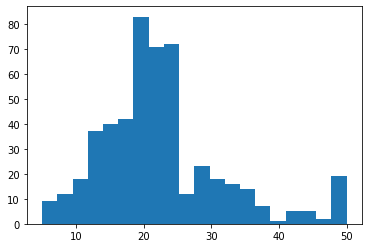

In [2]:
boston_X, boston_y = load_boston(return_X_y = True) #return_X_y =True，返回数据分为X，y；否则返回data，target的字典形式
print('boston_X.shape:', boston_X.shape)
plt.figure()
plt.hist(boston_y, bins = 20)
plt.show()

使用StandardScaler()对数据集中的变量进行标准化处理，再转换为张量，最后将数据加载进DataLoader方便训练

In [3]:
#数据进行标准化处理
ss = StandardScaler(with_mean = True, with_std = True)
boston_Xs = ss.fit_transform(boston_X)

#训练集X和y转换为张量
train_xt = torch.from_numpy(boston_Xs.astype(np.float32))
train_yt = torch.from_numpy(boston_y.astype(np.float32))

#将data和target整合到一起
train_data = Data.TensorDataset(train_xt, train_yt)

#定义一个数据加载器，将数据批处理
train_loader = Data.DataLoader(dataset = train_data, #指定数据集 
                               batch_size = 128, #批处理大小
                               shuffle = True, #打乱数据
                               num_workers = 1,) #使用两个进程


### 网络定义与训练方式1

在数据进行预处理后，可以使用即成Module的方式定义一个包含层的全连接神经网络

In [4]:
class MLPmodel(nn.Module): #所有模型都要继承nn.Module类
    def __init__(self): #构造方法
        super(MLPmodel, self).__init__() #这前三行是个固定模式，几乎都可以这么写
        self.hidden1 = nn.Linear(
            in_features = 13, #输入特征数量
            out_features = 10, #输出特征数量
            bias = True, #默认会有偏置
        )
        self.active1 = nn.ReLU()
        self.hidden2 = nn.Linear(10,10)
        self.active2 = nn.ReLU()
        self.regression = nn.Linear(10, 1)
    def forward(self, x):
        x = self.hidden1(x)
        x = self.active1(x)
        x = self.hidden2(x)
        x = self.active2(x)
        output = self.regression(x)
        return output

mlpl = MLPmodel()
print(mlpl)

MLPmodel(
  (hidden1): Linear(in_features=13, out_features=10, bias=True)
  (active1): ReLU()
  (hidden2): Linear(in_features=10, out_features=10, bias=True)
  (active2): ReLU()
  (regression): Linear(in_features=10, out_features=1, bias=True)
)


我们在定义一个网络模型时，主要定义两个部分。1.网络结构，2.定义网络结构的向前传播过程forward()函数

定义好模型后，我们对其进行训练

In [5]:
optimizer = optim.SGD(mlpl.parameters(), lr = 0.001)#定义优化器
criteon = nn.MSELoss()
train_loss_all = [] #保存损失函数的值
epochs = 30
import torch.optim.lr_scheduler as lr_scheduler

scheduler = lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1)

Text(0.5, 1.0, 'Train loss per iteration')

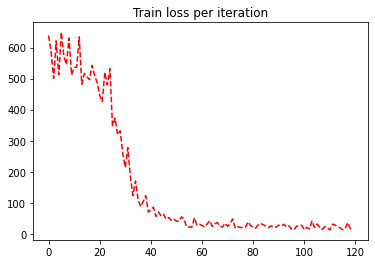

In [6]:
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        output = mlpl(data).flatten()
        train_loss = criteon(output, target)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        train_loss_all.append(train_loss.item())
#     scheduler.step()
    
plt.figure()
plt.plot(train_loss_all, 'r--')
plt.title('Train loss per iteration')

### 网络定义与训练方式2

我们在定义网络结构时，每层都指定了一个名称。在PyTorch中提供了可以将多个功能层连接在一起的函数nn.Sequential()，以大大方便网络向前传播函数的定义

In [7]:
class MLPmodel2(nn.Module):
    def __init__(self):
        super(MLPmodel2, self).__init__()
        self. hidden = nn.Sequential(
            nn.Linear(13, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
        )
        self.regression = nn.Linear(10,1)
    def forward(self, x):
        x = self.hidden(x)
        output = self.regression(x)
        return output

mlp2 = MLPmodel2()
print(mlp2)

MLPmodel2(
  (hidden): Sequential(
    (0): Linear(in_features=13, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
  )
  (regression): Linear(in_features=10, out_features=1, bias=True)
)


Text(0.5, 1.0, 'Train loss per iteration')

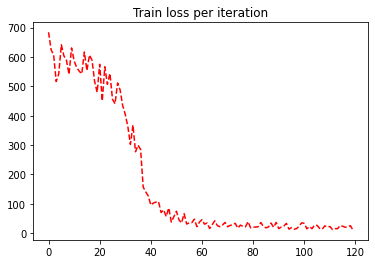

In [8]:
optimizer = optim.SGD(mlp2.parameters(), lr = 0.001)#定义优化器
criteon = nn.MSELoss()
train_loss_all = [] #保存损失函数的值
epochs = 30

for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        output = mlp2(data).flatten()
        train_loss = criteon(output, target)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        train_loss_all.append(train_loss.item())
#     scheduler.step()
    
plt.figure()
plt.plot(train_loss_all, 'r--')
plt.title('Train loss per iteration')

## PyTorch模型保存和加载方法

方法一，保存整个模型

In [9]:
#保存
torch.save(mlp2,'./models/mlp2.pkl')

In [10]:
#导入
mlp2load = torch.load('./models/mlp2.pkl')
mlp2load

MLPmodel2(
  (hidden): Sequential(
    (0): Linear(in_features=13, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
  )
  (regression): Linear(in_features=10, out_features=1, bias=True)
)

In [11]:
mlp2load.state_dict()

OrderedDict([('hidden.0.weight',
              tensor([[-0.0058, -0.1397, -0.0760, -0.1860,  0.0296,  0.3530, -0.0720, -0.3940,
                       -0.3101, -0.3187, -0.3135,  0.1764, -0.0633],
                      [-0.4014, -0.0777, -0.2316, -0.1347, -0.2266,  0.5957,  0.1331,  0.0955,
                       -0.3320, -0.2492, -0.0065, -0.0642, -0.3999],
                      [ 0.1620,  0.1116,  0.0054,  0.1560, -0.1858, -0.1545, -0.0089, -0.1966,
                       -0.1111,  0.1111, -0.1307, -0.0806,  0.1085],
                      [-0.2796,  0.0772, -0.1915,  0.0174, -0.2997,  0.3784, -0.1944, -0.3627,
                       -0.4716, -0.4029, -0.0403,  0.3282,  0.0620],
                      [-0.0071, -0.2813,  0.3766,  0.1662,  0.1545,  0.4594, -0.1505, -0.0423,
                        0.4687, -0.0396, -0.0357,  0.0810, -0.4900],
                      [ 0.1015,  0.1161, -0.3446, -0.0634, -0.3582,  0.3148, -0.3035,  0.1055,
                       -0.2953, -0.0907, -0.0186,  0

可以看到，模型保存不光保存了模型结构，连模型参数也一起作了保存

方法二：只保存模型的参数

In [ ]:
torch.save(mlp2.state_dict(), './models/mlp2_param.pkl')

In [ ]:
mlp2load2 = torch.load('./models/mlp2_param.pkl')

In [ ]:
mlp2load2